In [1]:
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//2)
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//2)
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y.reshape(-1, 1)

In [12]:
X,Y=gen_arti(data_type=2)
train_x,test_x,train_y,test_y=train_test_split(X,Y,train_size=0.9)
cl=RandomForestClassifier(random_state=0,max_depth=2)
cl.fit(train_x,train_y)
cl.score(test_x,test_y)

C:\Users\baris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.45

In [4]:
class Adaboost():
    def __init__(self,n_estimators):
        self.n_estimators = n_estimators
        self.estimators = []
        self.alpha = []
        self.errors=[]
    def fit(self,X,Y):
        n_samples, _ = X.shape
        sample_weights = np.array([1/n_samples]*n_samples)
        print(sum(sample_weights))
        #sample_weights=sample_weights.reshape(n_samples)
        #print(sample_weights.shape)
        for _ in range(self.n_estimators):
            sample_weights=sample_weights.reshape(n_samples)
            # Etape 1 calcul  des h_t()
            classif_faible = DecisionTreeClassifier(max_depth=2)
            classif_faible.fit(X, Y, sample_weights)

            # Etape 2 Calcul de l'erreur
            y_pred = classif_faible.predict(X)
            #print(Y.T)
            error = np.sum(sample_weights * (np.where(y_pred != Y.T,1,0)))
            #print(error)

            # Etape 3 Calcules des alphas
            alpha_t = 0.5 * np.log((1 - error) / (error))
            self.alpha.append(alpha_t)
            #print(sample_weights.shape)
            #print(alpha_t)
            # Mise à jour de D
            #print(np.exp(-alpha_t * Y * y_pred))
            #print(len(np.sum(np.exp(-alpha_t * Y * y_pred),axis=1)))
            sample_weights =np.sum(sample_weights*np.exp(-alpha_t * Y * y_pred),axis=1)
            sample_weights /= np.sum(sample_weights)
            #print(sample_weights.shape)

            # Save the weak learner
            self.estimators.append(classif_faible)
            self.errors.append(error)
    def predict(self, X):
        n_samples, _ = X.shape
        predictions = np.zeros(n_samples)

        for estimator, estimator_poids in zip(self.estimators, self.alpha):
            predictions += estimator.predict(X) * estimator_poids

        return np.sign(predictions)
    def accuracy(self,X,Y):
        Y_pred=self.predict(X)
        return np.mean(np.where(Y.T==Y_pred,1,0))
    
        

In [14]:
data_x,data_y=gen_arti(data_type=1)
train_x,test_x,train_y,test_y=train_test_split(data_x,data_y,train_size=0.9)
my_booster=Adaboost(500)
my_booster.fit(train_x,train_y)
my_booster.accuracy(test_x,test_y)


0.9999999999999802


0.45

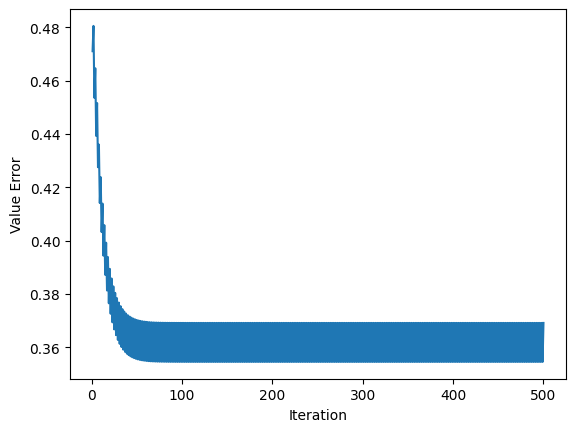

In [15]:
x=range(1,501)
plt.xlabel("Iteration")
plt.ylabel("Value Error")
plt.plot(x,my_booster.errors)

In [7]:
print(my_booster.alpha)

[0.07346521592688576, 0.04288082284007907, 0.10508077930077268, 0.0662708566994155, 0.12236055026270232, 0.07908253458058666, 0.13183161526259007, 0.08611124536285385, 0.13702880319668834, 0.08996992004008866, 0.1398822430933751, 0.09208893942372938, 0.1414492868614622, 0.0932527906144542, 0.1423099846579065, 0.09389207440938072, 0.14278275511593733, 0.09424323658418325, 0.14304245161307969, 0.09443613618094199, 0.143185107792102, 0.09454210060758116, 0.1432634723783725, 0.09460030981588752, 0.1433065202523378, 0.09463228586774952, 0.14333016773945773, 0.09464985129973054, 0.14334315803616887, 0.0946595005438778, 0.1433502940153479, 0.09466480118023415, 0.14335421403562537, 0.0946677129891206, 0.1433563674280579, 0.09466931253904767, 0.14335755035554318, 0.09467019122316331, 0.1433582001755854, 0.09467067391257761, 0.14335855714261309, 0.09467093906938785, 0.14335875323607597, 0.09467108472854915, 0.14335886095652012, 0.09467116474380995, 0.14335892013082388, 0.09467120869876681, 0.143